# MIDS 207 Project - Classification of White Blood Cells
## Zachary Zimmerman, Adeleke Coker, Jay Prakash

### Introduction

One major issue in the detection of bone cancers is the identification and labeling of cells. A bone marrow biopsy can reveal the cell composition of a patient, but lab techs still need to stain and image every cell and a trained expert needs to be able to distinguish the cell types. This is a time and labor-intensive undertaking that slows down the diagnostic pipeline, costing potential bone cancer patients valuable seconds. One way to help speed up the process would be reliable classification of each cell type. Here, we attempt to implement a convolutional neural network (CNN) that is capable of distinguishing different cell types present in a bone marrow biopsy. We will be using the [bone marrow cell classification dataset](https://www.kaggle.com/datasets/andrewmvd/bone-marrow-cell-classification) from Kaggle. This dataset contains just over 170,000 images that have been de-identified and annotated by experts. The images come from the marrow biopsies of 945 patients and have all been stained with the same method. Images were captured via oil immersion and 40x magnification under a bright field microscope. All samples were processed in the Munich Leukemia Laboratory with the same equipment and post-processed using the same software.

To make our model, we will be using TensorFlow 2.6. While more recent versions are available, we experimented with putting data augmentation layers instead of during data preprocessing and thus this version is more suitable. Training was done on an Amazon SageMaker ml.g4dn.xlarge instance equipped with 4 vCPUs, 16 GiB memory, and 1 GPU.

In [76]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import (SpatialDropout2D,
                                     Conv2D,
                                     LeakyReLU,
                                     ReLU,
                                     MaxPooling2D,
                                     Flatten, 
                                     Dense,
                                     Dropout, 
                                     BatchNormalization,
                                     Resizing,
                                     Rescaling,
                                     RandomCrop,
                                     RandomFlip)
from tensorflow.keras.utils import load_img

In [77]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Data Loading

The dataset from Kaggle was in the following format: directories containing images where the name of the directory is the label of all images. Loading and manipulating the images in memory would have been very inefficient, so the filepaths and image labels were first extracted using the following code, and the labels were encoded as sparse integer labels using the scikit-learn LabelEncoder class.

In [4]:
def define_paths(data_dir):
    filepaths = []
    labels = []
    folders = os.listdir(data_dir)
    for folder in folders:
        label = str(folder)
        folder_path = os.path.join(data_dir, folder)
        for roots, dirs, files in os.walk(folder_path):
            for file in files:
                if file.lower().endswith('.jpg'):
                    filepaths.append(os.path.join(roots,file))
                    labels.append(label)
    return filepaths, labels
    

In [5]:
def define_df(files, labels):
    encoder = LabelEncoder()
    
    file_series = pd.Series(files, name='filepaths')
    label_series = pd.Series(labels, name='labels')
    category_series = pd.Series(encoder.fit_transform(label_series),name='categories')
    return pd.concat([file_series, label_series, category_series], axis=1)

In [6]:
def create_df(data_dir):
    files, labels = define_paths(data_dir)
    df = define_df(files,labels)
    strat = df['labels']
    train_df, test_df = train_test_split(df, 
                                         train_size = 0.8,
                                         shuffle=True,
                                         stratify=strat)
    
    train_df, val_df = train_test_split(train_df, 
                                    train_size=0.8,
                                    shuffle=True,
                                    stratify=train_df['labels'])
    return train_df, val_df, test_df

In [82]:
train_df, val_df, test_df = create_df('./207Project/bone_marrow_cell_dataset')

In [96]:
class_counts = train_df['labels'].value_counts().shape[0]
print(train_df['labels'].value_counts())
print('\n')
print("Number of categories:", class_counts)

NGS    18831
EBO    17533
LYT    16795
ART    12563
PMO     7676
BLA     7662
NGB     6379
PLM     4882
MYB     4197
EOS     3765
MON     2586
NIF     2264
MMZ     1955
PEB     1754
BAS      282
HAC      262
OTH      188
LYI       42
FGC       30
KSC       27
ABE        6
Name: labels, dtype: int64


Number of categories: 21


In [104]:
class_names = train_df['labels'].value_counts().index.tolist()

train_counts = train_df['labels'].value_counts().tolist()
val_counts = val_df['labels'].value_counts().tolist()
test_counts = test_df['labels'].value_counts().tolist()

### Initial EDA
We can see that the data amounts to 21 highly imbalanced classes, as shown below. The extremely imbalanced data likely means that there will be significant issues with classification.

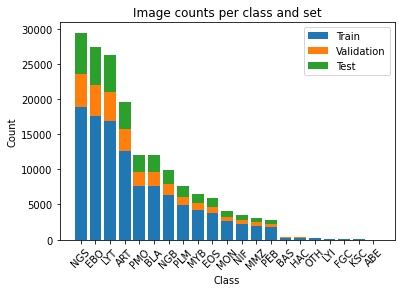

In [105]:
x_pos = np.arange(class_counts)


# Define the colors for each set
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create the bar plot
plt.bar(x_pos, train_counts, color=colors[0], label='Train')
plt.bar(x_pos, val_counts, bottom=train_counts, color=colors[1], label='Validation')
plt.bar(x_pos, test_counts, bottom=np.array(train_counts)+np.array(val_counts), color=colors[2], label='Test')

# Set axis labels and title
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Image counts per class and set")

# Add legend, rotate x-axis labels, and set class names as labels
plt.legend()
plt.xticks(x_pos, class_names, rotation=45)

plt.show()

First, let's take a look at the images. To do so, we need to first define a batch generator using the tensorflow Sequence class. Then, we will instantiate the images and select a few random ones from the first batch.

In [106]:
import cv2
class MyCustomGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, image_filenames, labels, batch_size, augment=False):
        self.image_filenames=image_filenames
        self.labels=labels
        self.batch_size=batch_size
        self.augment=augment

    def __len__(self):
        return (np.ceil(len(self.image_filenames)/float(self.batch_size))).astype(int)
    
    def __getitem__(self, idx) :
        batch_x = self.image_filenames.iloc[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels.iloc[idx * self.batch_size : (idx+1) * self.batch_size]
    
        loaded_images = [cv2.imread(str(file_name),1) for file_name in batch_x]
        loaded_images = map(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB), loaded_images)  # Convert BGR to RGB

        batch_x = np.array([img for img in loaded_images]).astype('int')
        batch_y = np.array(batch_y)

        return batch_x, batch_y

In [107]:
batch_size=256

training_batch_generator=MyCustomGenerator(train_df['filepaths'],
                                           train_df['categories'],
                                           batch_size,
                                           augment=True)
validation_batch_generator=MyCustomGenerator(val_df['filepaths'],
                                             val_df['categories'],
                                             batch_size,
                                             augment=False)

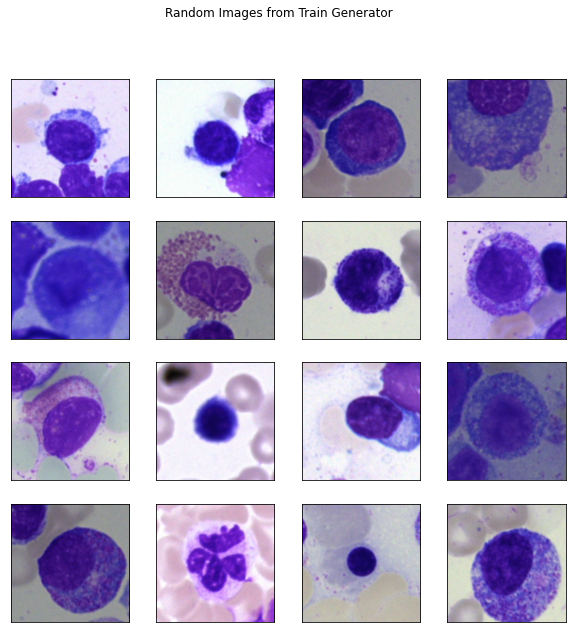

In [128]:
# Define a function to plot a grid of images
def plot_images(images):
    # Get the number of rows and columns for our grid
    num_rows = int(np.ceil(np.sqrt(len(images))))
    num_cols = int(np.ceil(len(images) / num_rows))

    # Create a new figure with the appropriate size
    fig, axs = plt.subplots(num_rows, num_cols, figsize = (10,10))

    # Loop through the images and plot them
    for i, image in enumerate(images):
        row = i // num_cols
        col = i % num_cols
        ax = axs[row][col]
        ax.imshow(image.astype(np.uint8)) # Convert the image to uint8 before plotting
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any extra axes
    for i in range(len(images), len(axs)):
        axs[i].axis("off")
        
    fig.set_facecolor('white')

    # Set the title
    fig.suptitle("Random Images from Train Generator")

# Get the first batch of images from the generator
batch = training_batch_generator[0][0]

# Plot a random subset of the images
random_indices = np.random.choice(len(batch), size=16, replace=False)
images = batch[random_indices]

plot_images(images)

plt.show()

As we can see, the images look very similar, at least to the naked eye. Let's first construct a baseline model to see how it performs. This architecture will be a simple one based on [Tiny VGG](https://poloclub.github.io/cnn-explainer/) and we will attempt to classify all the cells with no further data processing.

In [139]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath= "~/" +"checkpoints/" "mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=(3,3), # can also be (2, 2)
                         activation="relu", 
                         input_shape=(250, 250, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=(2, 2), # pool_size can also be (3, 3)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(21, activation="softmax") # multiclass classification activation output
])

# Compile the model
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 248, 248, 10)      280       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 246, 246, 10)      910       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 123, 123, 10)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 121, 121, 10)      910       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 119, 119, 10)      910       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 59, 59, 10)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 34810)            

In [140]:
# Fit the model
history_1 = model_1.fit(training_batch_generator,
                        epochs=5,
                        steps_per_epoch=len(training_batch_generator),
                        validation_data=validation_batch_generator,
                        validation_steps=len(validation_batch_generator), callbacks=callbacks)

Epoch 1/5
429/429 [==============================] - 692s 2s/step - loss: 8.0792 - sparse_categorical_accuracy: 0.3939 - val_loss: 1.8590 - val_sparse_categorical_accuracy: 0.4601

Epoch 00001: val_loss improved from inf to 1.85902, saving model to ~/checkpoints/mymodel_1
INFO:tensorflow:Assets written to: ~/checkpoints/mymodel_1/assets


INFO:tensorflow:Assets written to: ~/checkpoints/mymodel_1/assets


Epoch 2/5
429/429 [==============================] - 682s 2s/step - loss: 1.6988 - sparse_categorical_accuracy: 0.4842 - val_loss: 1.7517 - val_sparse_categorical_accuracy: 0.4770

Epoch 00002: val_loss improved from 1.85902 to 1.75175, saving model to ~/checkpoints/mymodel_2
INFO:tensorflow:Assets written to: ~/checkpoints/mymodel_2/assets


INFO:tensorflow:Assets written to: ~/checkpoints/mymodel_2/assets


Epoch 3/5
429/429 [==============================] - 677s 2s/step - loss: 1.5601 - sparse_categorical_accuracy: 0.5185 - val_loss: 1.7636 - val_sparse_categorical_accuracy: 0.4751

Epoch 00003: val_loss did not improve from 1.75175
Epoch 4/5
429/429 [==============================] - 672s 2s/step - loss: 1.4848 - sparse_categorical_accuracy: 0.5372 - val_loss: 1.7472 - val_sparse_categorical_accuracy: 0.4813

Epoch 00004: val_loss improved from 1.75175 to 1.74719, saving model to ~/checkpoints/mymodel_4
INFO:tensorflow:Assets written to: ~/checkpoints/mymodel_4/assets


INFO:tensorflow:Assets written to: ~/checkpoints/mymodel_4/assets


Epoch 5/5
429/429 [==============================] - 667s 2s/step - loss: 1.3999 - sparse_categorical_accuracy: 0.5594 - val_loss: 1.7343 - val_sparse_categorical_accuracy: 0.4896

Epoch 00005: val_loss improved from 1.74719 to 1.73433, saving model to ~/checkpoints/mymodel_5
INFO:tensorflow:Assets written to: ~/checkpoints/mymodel_5/assets


INFO:tensorflow:Assets written to: ~/checkpoints/mymodel_5/assets


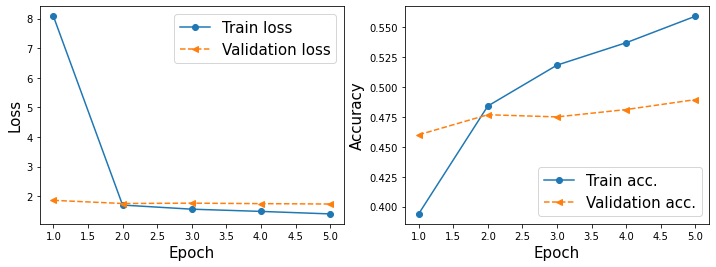

In [142]:
hist_1 = history_1.history
x_arr = np.arange(len(hist_1['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist_1['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist_1['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_1['sparse_categorical_accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist_1['val_sparse_categorical_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

We can see from the above charts that the model severely overfits the training data, with very little change in the validation data. To further illustrate this, below is the confusion matrix for the baseline model. Again, we see that this model severely overestimates the more highly represented classes.

In [144]:
# Get the true labels and predicted labels from the model
y_true = np.array([])
for batch in validation_batch_generator:
    y_true = np.concatenate((y_true, batch[1]))
y_true = y_true.astype('float')

y_pred = model_1.predict(validation_batch_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

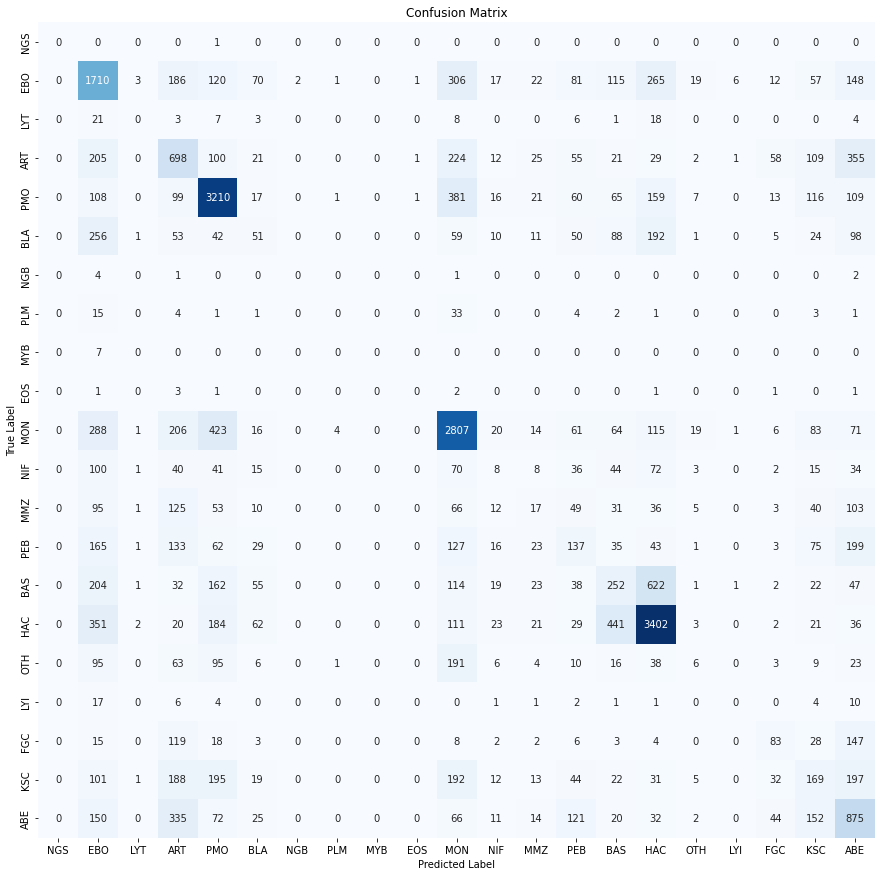

In [152]:
# Plot the confusion matrix using Seaborn

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=class_names, yticklabels=class_names, cbar=False, fmt='.0f', ax=ax)

# Set plot labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()

### Recreating a Model from Literature
Referring to literature, it seems that classification of blood cells via CNN is an open problem due to the size and complexity of datasets. Various work was done exploring different architectures in our work, including ResNets, VGG transfer learning, and simply increasing the depth of the convolutional neural networks (work not shown, I unfortunately did not keep track of my efforts and kept modifying the same cell below). We also experimented with cutting the data down, and trying to perform classification on a subset of classes.

Ultimately, there was a few insights from this exploration of models and subsets. One is that some of the classes introduce too much noise in the model. For example, the classes 'ART' and 'OTH', standing for artefacts and other cells respectively, encompass too broad of a category for the model to learn anything meaningful. Attempts at distinguishing blood cells from other cells or blood cells from artefacts did not yield any fruit. In fact, a four category classifier was stuck at around 30% when artefacts were included, but rapidly shot up to ~80% on validation data after one epoch when artefacts were swapped out with another category. Thus, the conclusion was made that using the entirety of the dataset was not suitable for our purposes. Additionally, attempting to implement many other architectures was not satisfactory as the other architectures were implemented on vastly different datasets, and the reporting of their performance metrics was poor and hard to compare to. 

Eventually, we stumbled upon a paper by [Shahin et al](https://scholar.cu.edu.eg/sites/default/files/amrarsha/files/deeplearning_paper_0.pdf). This paper used a relatively simple convolutional neural network for a well defined task: distinguishing different leukocytes.

There are five types of leukocytes: monocytes, eosinophils, basophils, and neutrophils. The paper used a small dataset of around 2000 samples total, with a distribution of cells similar to our dataset. This seemed like a much more doable task, as the paper provided a confusion matrix that we could use as reference for the performance of our model. However, we needed to make a slight modification. In the original paper, neutrophils are classified under a single group. In our dataset, neutrophils have distinct 'band' and 'segmented' classes. A quick search reveals that they are the same cell at different levels of developmental maturity. Nevertheless, we decided to keep the classes separate to push the performance of the model.

In [153]:
train_df.loc[train_df['labels'].isin(['NGS']), 'categories'] = 0 # segmented neutrophil

train_df.loc[train_df['labels'].isin(['NGB']), 'categories'] = 1 # band neutrophil

train_df.loc[train_df['labels'].isin(['BAS']), 'categories'] = 2 # basophils

train_df.loc[train_df['labels'].isin(['LYT']), 'categories'] = 3 # lymphocytes

train_df.loc[train_df['labels'].isin(['MON']), 'categories'] = 4 # monocytes

train_df.loc[train_df['labels'].isin(['EOS']), 'categories'] = 5 # eosinophils

train_df = train_df.loc[train_df['labels'].isin(['NGS', 'NGB', 'BAS', 'LYT', 'MON', 'EOS'])]

val_df.loc[val_df['labels'].isin(['NGS']), 'categories'] = 0 # segmented neutrophil

val_df.loc[val_df['labels'].isin(['NGB']), 'categories'] = 1 # band neutrophil

val_df.loc[val_df['labels'].isin(['BAS']), 'categories'] = 2 # basophils

val_df.loc[val_df['labels'].isin(['LYT']), 'categories'] = 3 # lymphocytes

val_df.loc[val_df['labels'].isin(['MON']), 'categories'] = 4 # monocytes

val_df.loc[val_df['labels'].isin(['EOS']), 'categories'] = 5 # eosinophils

val_df = val_df.loc[val_df['labels'].isin(['NGS', 'NGB', 'BAS', 'LYT', 'MON', 'EOS'])]



In [154]:
train_df[['labels','categories']].value_counts()

labels  categories
NGS     0             18831
LYT     3             16795
NGB     1              6379
EOS     5              3765
MON     4              2586
BAS     2               282
dtype: int64

In [155]:
train_df[['categories','labels']].value_counts()/train_df[['categories','labels']].value_counts().sum()

categories  labels
0           NGS       0.387166
3           LYT       0.345306
1           NGB       0.131153
5           EOS       0.077409
4           MON       0.053168
2           BAS       0.005798
dtype: float64

In [156]:
ngs_indices = train_df[train_df['labels']=='NGS'].index
lyt_indices = train_df[train_df['labels']=='LYT'].index

ngs_subsample = train_df.loc[ngs_indices].sample(n=6400) # undersample the largest classes
lyt_subsample = train_df.loc[lyt_indices].sample(n=6400)

subsampled_classes = pd.concat([ngs_subsample, lyt_subsample])

train_df = pd.concat([subsampled_classes, train_df.loc[train_df['labels'].isin(['NGB', 'EOS', 'MON', 'BAS'])]])

train_df[['labels','categories']].value_counts()

labels  categories
LYT     3             6400
NGS     0             6400
NGB     1             6379
EOS     5             3765
MON     4             2586
BAS     2              282
dtype: int64

In [157]:
train_df[['categories','labels']].value_counts()/train_df[['categories','labels']].value_counts().sum()

categories  labels
0           NGS       0.247947
3           LYT       0.247947
1           NGB       0.247133
5           EOS       0.145862
4           MON       0.100186
2           BAS       0.010925
dtype: float64

In [21]:
def standardize(input_layer):
    x = Resizing(50, 50)(input_layer)
    x = Rescaling(scale=1./255)(x)
    return x

In [30]:
def augment(input_layer):
    x = RandomFlip()(input_layer)
    x = RandomCrop(225,225)(x)
    return x

In [16]:
batch_size=256

training_batch_generator=MyCustomGenerator(train_df['filepaths'],
                                           train_df['categories'],
                                           batch_size,
                                           augment=True)
validation_batch_generator=MyCustomGenerator(val_df['filepaths'],
                                             val_df['categories'],
                                             batch_size,
                                             augment=False)


In [31]:
def conv_block(x,
               filters,
               kernel_size, 
               strides,
               kernel_initializer,
               activation=ReLU(),
               padding='same'):
    x = Conv2D(filters,
                kernel_size, 
                strides, 
                padding=padding,
                kernel_initializer=kernel_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [32]:
def dense_block(input_layer, num_nodes, kernel_regularizer=None, dropout=None):
    x = Dense(num_nodes, kernel_regularizer=kernel_regularizer)(input_layer)
    x = ReLU()(x)
    if dropout:
        x = Dropout(dropout)(x)
    return x

For preprocessing, the authors resized the images to very small image sizes as they found this to give the best boost in performance. They settled on 50x50 as the optimal resizing target, so we also resized our images to 50x50 as well as normalized the RGB values to [0..1]. Additionally, we provided data augmentation layers in the form of RandomFlip() and RandomCrop() before resizing and rescaling, which gave a slight performance boost to the model. Additionally, we chose to initialize our weights using the He normal method. The authors did not disclose how their weights were initialized.

Our first pass at training the model used the complete 6 classes mentioned before. However, we found that model performance was not improving past ~70%. We first tried oversampling the underrepresented classes, but this did not lead to any improvement in model performance. Referring back to the paper, the authors mentioned that the extreme resizing involved in their approach may cause some data loss, so that subtle patterns the images are lost. Thus, their method is best suited to small datasets since the network will learn mostly high-level features due to the image size. With this in mind, we decided to try undersampling as an approach. This involved taking 6400 random samples from the most heavily represented classes (segmented neutrophils and lymphocytes) so that their sample size was close to the next most heavily represented class, band neutrophils.

The model was then trained for 90 epochs using an Adam optimizer with a learning rate of 0.001. Unfortunately, the model was trained in 30-epoch batches, the weights saved, and then reloaded for the next batch. As a result, a complete training history of the model is not available.

The sparse categorical accuracy was tracked across each epoch, and the final training and validation accuracies were 96% and 86%, respectively. The training history of the final epoch batch is available, and we can see that it was beginning to overfit the training data with no respective rise in validation accuracy. Thus, the model was not trained any more and evaluation was stopped.


In [33]:
def build_model():
    """
    Builds a convolutional neural network for identification of blood cells
    based on this architecture:
    https://scholar.cu.edu.eg/sites/default/files/amrarsha/files/deeplearning_paper_0.pdf
    """
    
    input_layer = tf.keras.layers.Input((None, None, 3))
    
    x = augment(input_layer) #Random flip and random crop
    x = standardize(x) # Resize to 50x50 image and normalize RGB values
    x = conv_block(x, 64, 5, 1, 'he_normal', ReLU(), padding = 'valid') # Convolutional layer 1
    x = MaxPooling2D(pool_size = (2,2), strides = 2)(x)
    
    x = conv_block(x, 256, 5, 1, 'he_normal', ReLU(), padding='valid') # Convolutional layer 2
    x = MaxPooling2D(pool_size = (2,2), strides = 2)(x)
    
    x = conv_block(x, 512, 3, 1, 'he_normal', ReLU(), padding='valid') # Convolutional layer 3
    
    x = Flatten()(x)
    
    x = dense_block(x, 512) # Feature extraction
        
    output_layer = Dense(6, activation = 'softmax')(x) # Classification
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model

In [195]:
tf.keras.backend.clear_session()
model = build_model()

In [196]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
random_flip (RandomFlip)     (None, None, None, 3)     0         
_________________________________________________________________
random_crop (RandomCrop)     (None, 225, 225, 3)       0         
_________________________________________________________________
resizing (Resizing)          (None, 50, 50, 3)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 64)        4864      
_________________________________________________________________
re_lu (ReLU)                 (None, 46, 46, 64)        0     

In [197]:
model.load_weights('my_model_weights.h5')

In [47]:
tf.keras.backend.clear_session()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',
                                                            patience=5,  # Number of epochs to wait before stopping training
                                                            min_delta=0.001,  # Minimum change in the monitored metric
                                                            mode='max',  # Stop training when the monitored metric stops increasing
                                                            verbose=1)


history = model.fit(training_batch_generator,
                    steps_per_epoch=len(training_batch_generator),
                    epochs=30,
                    verbose=1,
                    validation_data=validation_batch_generator,
                    validation_steps=len(validation_batch_generator))

Epoch 1/30
101/101 [==============================] - 174s 2s/step - loss: 0.1421 - sparse_categorical_accuracy: 0.9479 - val_loss: 0.5443 - val_sparse_categorical_accuracy: 0.8579
Epoch 2/30
101/101 [==============================] - 169s 2s/step - loss: 0.1383 - sparse_categorical_accuracy: 0.9488 - val_loss: 0.5688 - val_sparse_categorical_accuracy: 0.8528
Epoch 3/30
101/101 [==============================] - 168s 2s/step - loss: 0.1389 - sparse_categorical_accuracy: 0.9496 - val_loss: 0.5631 - val_sparse_categorical_accuracy: 0.8618
Epoch 4/30
101/101 [==============================] - 171s 2s/step - loss: 0.1367 - sparse_categorical_accuracy: 0.9503 - val_loss: 0.5928 - val_sparse_categorical_accuracy: 0.8621
Epoch 5/30
101/101 [==============================] - 170s 2s/step - loss: 0.1321 - sparse_categorical_accuracy: 0.9512 - val_loss: 0.6388 - val_sparse_categorical_accuracy: 0.8461
Epoch 6/30
101/101 [==============================] - 170s 2s/step - loss: 0.1414 - sparse_cate

In [48]:
model.save_weights('my_model_weights.h5')


### Evaluating Model Performance

The following is the confusion matrix and classification report for the model when evaluated on the test data. We can see that the model has a hard time telling segmented and band neutrophils apart. This is to be expected since they are simply the same cell type at different stages in the maturation cycle. This is not a problem, as the original model was intended to lump all neutrophils together. Relative to the other four cell types, there are few false positives and even fewer false negatives. The precision, recall, and F1-scores of segmented neutrophils are ~90%, and ~70% for band neutrophils. We can also see that lymphocytes were the best-performing class with precision, recall, and F1 of 91%, 97%, and 94%, respectively. Similarly, eosinophils have good metrics. The model begins to break down for basophils and monocytes, the two most under-represented classes. Monocytes are most commonly confused for lymphocytes, and basophils have more false negatives than there are true positives. The authors touted a much higher true positive rate for basophils, with 9/11 correctly identified. The reason for this discrepancy is unclear without further exploration. The authors speculate that their model is only good for small datasets due to the restrictive nature of resizing images down to 50x50. This may reasoning may explain why our confusion matrix has a much higher false negative than false positive rate for the two poorly-performing classes. If the model is only suited for small datasets and indeed overfits easily due to only learning low-level features, we would expect to see under-represented classes have more false negatives since the model has confused their low-level features with those of other classes. Perhaps further under-sampling to reduce the dataset would lead to a better performing model. Unfortunately, the time constraints of this project render such an exploration unfeasible. There is also the possibility that the original architecture is flawed, and the model was overfitting to smaller dataset. 

In [49]:
test_df.loc[test_df['labels'].isin(['NGS']), 'categories'] = 0 # segmented neutrophil

test_df.loc[test_df['labels'].isin(['NGB']), 'categories'] = 1 # band neutrophil

test_df.loc[test_df['labels'].isin(['BAS']), 'categories'] = 2 # basophils

test_df.loc[test_df['labels'].isin(['LYT']), 'categories'] = 3 # lymphocytes

test_df.loc[test_df['labels'].isin(['MON']), 'categories'] = 4 # monocytes

test_df.loc[test_df['labels'].isin(['EOS']), 'categories'] = 5 # eosinophils

test_df = test_df.loc[test_df['labels'].isin(['NGS', 'NGB', 'BAS', 'LYT', 'MON', 'EOS'])]

In [50]:
test_batch_generator=MyCustomGenerator(test_df['filepaths'],
                                           test_df['categories'],
                                           batch_size,
                                           augment=True)

In [51]:
y_pred = model.predict(test_batch_generator)

In [52]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_labels = y_pred_labels.astype('float')

In [67]:
y_labels = np.array([])
for batch in test_batch_generator:
    y_labels = np.concatenate((y_labels,batch[1]))
y_labels = y_labels.astype('float')

In [68]:
y_pred_labels.shape

(15200,)

In [69]:
y_labels.shape

(15200,)

In [70]:
cm = confusion_matrix(y_labels, y_pred_labels)

<AxesSubplot:>

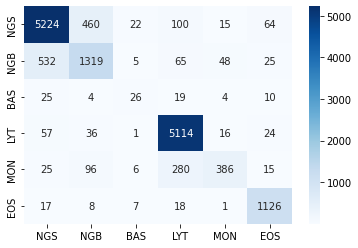

In [71]:
import seaborn as sns
x_labels = ['NGS', 'NGB', 'BAS', 'LYT', 'MON', 'EOS']
y_categories = ['NGS', 'NGB', 'BAS', 'LYT', 'MON', 'EOS']

sns.heatmap(cm, cmap="Blues", annot=True, fmt='.0f', xticklabels=x_labels, yticklabels=y_categories)

In [73]:
print(classification_report(y_labels, y_pred_labels))

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89      5885
         1.0       0.69      0.66      0.67      1994
         2.0       0.39      0.30      0.34        88
         3.0       0.91      0.97      0.94      5248
         4.0       0.82      0.48      0.60       808
         5.0       0.89      0.96      0.92      1177

    accuracy                           0.87     15200
   macro avg       0.76      0.71      0.73     15200
weighted avg       0.86      0.87      0.86     15200



To further explore the model, let's take a look at the feature maps. There are three convolutional layers in the model and we will look at the output for each one. The latter two convolutional layers have too many feature maps to realistically plot, so we will restrict those to the first 64 each.

In [168]:
# summarize feature map shapes
for i in range(len(model.layers)):
     layer = model.layers[i]
 # check for convolutional layer
     if 'conv' not in layer.name:
         continue
     # summarize output shape
     print(i, layer.name, layer.output.shape)

5 conv2d (None, 46, 46, 64)
8 conv2d_1 (None, 19, 19, 256)
11 conv2d_2 (None, 7, 7, 512)


In [202]:
first_conv = tf.keras.Model(inputs = model.inputs, outputs = model.layers[5].output)
second_conv = tf.keras.Model(inputs = model.inputs, outputs = model.layers[8].output)
third_conv = tf.keras.Model(inputs = model.inputs, outputs = model.layers[11].output)

In [181]:
img_batch = test_batch_generator[0][0]

In [182]:
img_batch.shape

(256, 250, 250, 3)

In [203]:
feature_maps_1 = first_conv.predict(img_batch)
feature_maps_2 = second_conv.predict(img_batch)
feature_maps_3 = third_conv.predict(img_batch)

In [219]:
def plot_feature_maps(feature_maps):
    #plot the first 64 maps in an 8x8 square
    square = 8
    ix = 1
    fig, axes = plt.subplots(square, square, figsize = (10,10))
    for i in range(square):
         for j in range(square):
             # specify subplot and turn of axis
            ax = axes[i][j]
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            ax.imshow(feature_maps[3, :, :, ix-1], cmap = 'gray')
            ix += 1
    # show the figure
    plt.show()

Looking below at the output of the first convolutional layer, we see that the model is picking up the outlines of cells, as well as the outlines of the nuclei. It appears that the second convolutional layer is detecting the nuclei further, as evidenced by the dark shadows where the nuclei are in the cell. The third layer is now unintelligible to the human eye, and it's unsure what is being detected. However, the first two convolutional layers detecting the shape and nuclei of cells is promising, as it shows that our model is indeed learning to distinguish cell types based on real-world features intead of picking up on pat

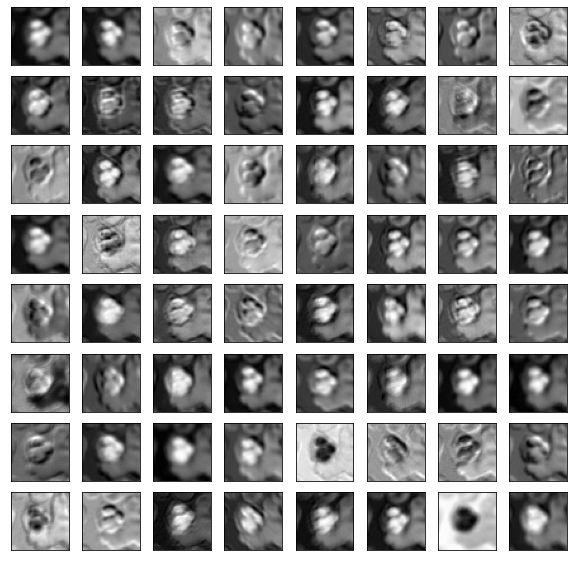

In [220]:
plot_feature_maps(feature_maps_1)

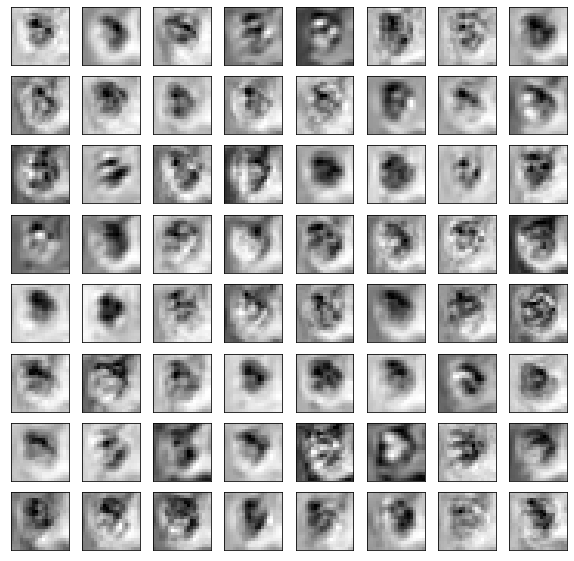

In [221]:
plot_feature_maps(feature_maps_2)

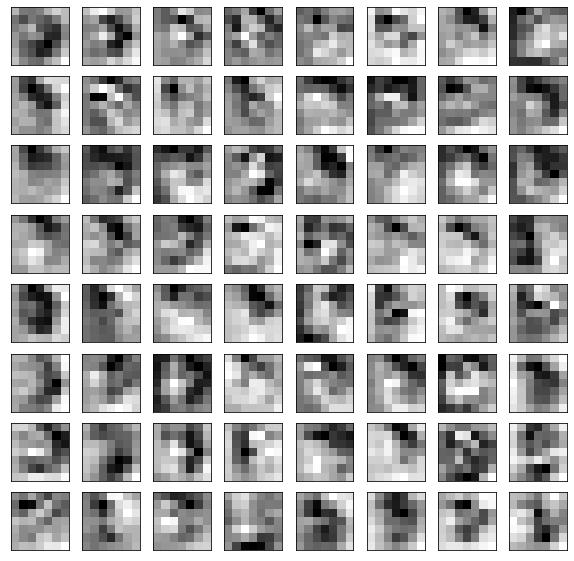

In [222]:
plot_feature_maps(feature_maps_3)

### Conclusion and Reflection

In conclusion, distinguishing different cell types is a very difficult task, as models have a hard time extracting meaningful features. In this paper, we have re-implemented a model designed to distinguish white blood cell types and evaluated its performance on our own dataset. The model does not perform as reported. This may be due to a variety of factors such as: the model has overfit to the larger classes since it resizes images to a much smaller size, 50x50; the model itself does not generalize well to other images and was only suitable for the specific dataset originally used; the architecture is fine, but we did not do adequate hyperparameter tuning. Additionally, we did not combine our neutrophil classes, and we can see that the model commonly confuses the two. Separating the two neutrophil types out may have introduced unnecessary complexity to the model, taking away from its ability to distinguish the low-level features of other classes. Overall, the model shows a lot of promise but more fine-tuning should be done to correctly classify the underrepresented classes. Medical technology still appears to be a long way from being able to successfully classify blood cells, let alone diagnose abnormal cells.